In [203]:
import numpy as np
import matplotlib.pyplot as plt
from random import choices,sample
from scipy.stats import bootstrap, dirichlet
from scipy.spatial import Delaunay, ConvexHull, Delaunay, convex_hull_plot_2d
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

1. Born-again random forests kernel
1.1. Generate sample from the convex hull

C:\Users\pengq\AppData\Local\Temp\ipykernel_23600\1344881483.py:11: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  vols = np.abs(np.linalg.det(deln[:, :dims, :] - deln[:, dims:, :])) / np.math.factorial(dims)


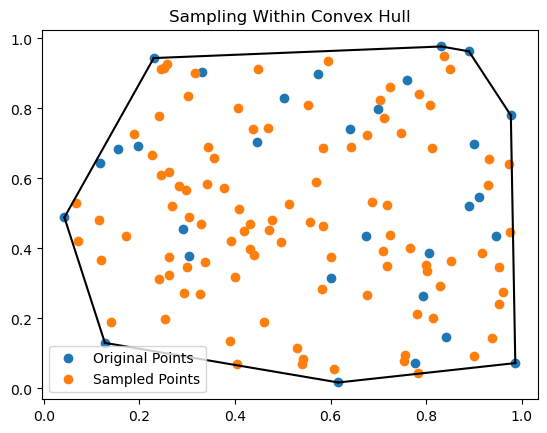

In [ ]:
def generate_random_points(num_points, seed=None):
    """Generate random points in 2D space."""
    rng = np.random.default_rng(seed)
    return rng.random((num_points, 2))

def sample_from_convex_hull(points, num_samples):
    """Sample points uniformly from the convex hull of the given points."""
    dims = points.shape[-1]
    hull_points = points[ConvexHull(points).vertices]
    deln = hull_points[Delaunay(hull_points).simplices]
    vols = np.abs(np.linalg.det(deln[:, :dims, :] - deln[:, dims:, :])) / np.math.factorial(dims)
    sampled_simplex_indices = np.random.choice(len(vols), size=num_samples, p=vols / vols.sum())
    return np.einsum('ijk, ij -> ik', deln[sampled_simplex_indices], dirichlet.rvs([1] * (dims + 1), size=num_samples))

def plot_points_with_convex_hull(original_points, sampled_points, hull):
    """Plot the original and sampled points along with the convex hull."""
    plt.plot(original_points[:, 0], original_points[:, 1], 'o', label='Original Points')
    plt.plot(sampled_points[:, 0], sampled_points[:, 1], 'o', label='Sampled Points')
    for simplex in hull.simplices:
        plt.plot(original_points[simplex, 0], original_points[simplex, 1], 'k-')
    plt.legend()
    plt.title('Sampling Within Convex Hull')
    plt.show()

seed = 561
original_points = generate_random_points(30, seed)
convex_hull = ConvexHull(original_points)
sampled_points = sample_from_convex_hull(original_points, 100)
plot_points_with_convex_hull(original_points, sampled_points, convex_hull)

Reference: https://stackoverflow.com/questions/59073952/how-to-get-uniformly-distributed-points-in-convex-hull

1.2. Construct born-again random forests kernel 

In [205]:
def brf_kernel(X_train, Y_train, B, black_box_model, n_estimators=100, random_state=0):
    """
    Return a born-again random forest kernel function.
    Parameters:
    - X_train: training input
    - Y_train: training output
    - B: number of samples to generate from the convex hull
    - black_box_model: regression model
    - n_estimators: number of trees in the random forest
    - random_state: controls both the randomness of the bootstrapping of the samples and the sampling of the features
    """
    # Sample new points from the convex hull of the training data
    Z = sample_from_convex_hull(X_train, B)
    
    # Fit the black box model to the training data
    black_box_model.fit(X_train, Y_train)
    
    # Predict the response for the new points using the fitted model
    f_Z = black_box_model.predict(Z)
    
    # Fit a new random forest to the (Z, f_Z) data
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state).fit(Z, f_Z)
    
    # Define the kernel function
    def kernel_func(x, t):
        leaf_node_x = model.apply(x.reshape(1, -1))
        leaf_node_t = model.apply(t.reshape(1, -1))
        return np.mean(leaf_node_x == leaf_node_t)
    
    return kernel_func

2. ad-hoc kernel
2.1. Construct ad-hoc kernel

In [206]:
def Voronoi(y, y_seed):
    '''
    Return the cell that y belongs to over the Voronoi partition generated by y_seed.
    '''
    distances = np.abs(y_seed - y)
    return distances.argmin()

def adhoc_kernel(X_train, Y_train, black_box_model, B = 10, M = 3, L = 12, bootstrap_size = 50):
    """
    Returns an ad-hoc kernel function based on the training data and a black box model.
    X_train: training input
    Y_train: training output
    black_box: regression model
    B: number of models
    M: number of selected predictors without replacement from all predictors
    L: number of random seeds for Voronoi partition
    bootstrap_size: number of samples per bootstrap
    """
    # Preallocate arrays for models and selected predictors
    models = [None] * B
    predictors = np.zeros((B, M), dtype=int)
    Y_seed = np.random.choice(Y_train, L, replace=True)

    # Precompute all bootstrapped samples and feature subsets
    rows_boot = np.random.choice(X_train.shape[0], (B, bootstrap_size), replace=True)
    cols_boot = np.array([sample(range(X_train.shape[1]), M) for _ in range(B)])

    for b in range(B):
        rows = rows_boot[b]
        cols = cols_boot[b]
        X_boot = X_train[rows][:, cols]
        Y_boot = Y_train[rows]
        model = black_box_model.fit(X_boot, Y_boot)
        models[b] = model
        predictors[b, :] = cols

    # Compute kernel function
    def kernel_func(x, t):
        kernel_distances = np.zeros(B)
        for b in range(B):
            model = models[b]
            cols = predictors[b, :]
            x_selected = x[cols].reshape(1, -1)
            t_selected = t[cols].reshape(1, -1)
            x_voronoi = Voronoi(model.predict(x_selected)[0], Y_seed)
            t_voronoi = Voronoi(model.predict(t_selected)[0], Y_seed)
            kernel_distances[b] = (x_voronoi == t_voronoi)
        return np.mean(kernel_distances)

    return kernel_func

2.2. Tuning hyperparameters
There are three hyperparameters, and we use train-validation-test split to determine the hyperparameters:
    - B: the number of models
    - M: the number of selected predictors without replacement from all predictors
    - L: the number of random seeds for Voronoi partition

In [297]:
from joblib import Parallel, delayed

# Generate simulation data
seed = 561
N = 100
p = 6
rng = np.random.default_rng(seed)
X = rng.normal(loc=0, scale=2, size = (N,p))
beta = np.array([1, 3, -1, 2.5, -4, 0]).reshape(p,1)
Y = rng.normal(loc = X@beta, scale = 4, size = (N,1)).reshape(-1)

# Split dataset into train, validation and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 561)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state = 561)

B_values = np.arange(20, 101, 20)
M_values = np.arange(2, p+1, 2)
L_values = np.arange(10, N+1, 20)
loss = np.zeros((len(B_values),len(M_values),len(L_values)))

def compute_kernel_matrix(kernel_func, X_data):
    n_samples = X_data.shape[0]
    kernel_matrix = np.empty((n_samples, n_samples))
    
    for i in range(n_samples):
        kernel_matrix[i, :] = Parallel(n_jobs=-1)(
            delayed(kernel_func)(X_data[i, :], X_data[j, :]) for j in range(n_samples)
        )
    
    # Normalize the kernel matrix
    kernel_matrix /= np.apply_along_axis(np.sum, 1, kernel_matrix).reshape(-1, 1)
    return kernel_matrix

# Train the model for each combination of hyperparameters
for B_idx, B in enumerate(B_values):
    for M_idx, M in enumerate(M_values):
           for L_idx , L in enumerate(L_values):
                kernel_func = adhoc_kernel(X_val, Y_val, black_box_model = RandomForestRegressor(), B = B, M = M, L = L, bootstrap_size = 50)
                kernel_matrix = compute_kernel_matrix(kernel_func, X_val)
                Y_pred = kernel_matrix @ Y_val
                loss[B_idx, M_idx, L_idx] = mean_squared_error(Y_val, Y_pred)

                print(f' B = {B}, M = {M}, L = {L}, Loss = {loss[B_idx, M_idx, L_idx]}')


# Find the optimal hyperparameters for the ad_hoc kernel
B_opt_idx, M_opt_idx, L_opt_idx = tuple([i.item() for i in np.where(loss == loss.min())])
B_opt_rf = B_values[B_opt_idx]
M_opt_rf = M_values[M_opt_idx]
L_opt_rf = L_values[L_opt_idx]

 B = 20, M = 2, L = 10, Loss = 35.1091552425555
 B = 20, M = 2, L = 30, Loss = 25.319056776352518
 B = 20, M = 2, L = 50, Loss = 34.92703975111321
 B = 20, M = 2, L = 70, Loss = 31.906525310758592
 B = 20, M = 2, L = 90, Loss = 35.20772881393371
 B = 20, M = 4, L = 10, Loss = 30.565759505412718
 B = 20, M = 4, L = 30, Loss = 28.939353476941797
 B = 20, M = 4, L = 50, Loss = 41.532637995500025
 B = 20, M = 4, L = 70, Loss = 29.352416489863238
 B = 20, M = 4, L = 90, Loss = 30.005855782563504
 B = 20, M = 6, L = 10, Loss = 55.99763283521462
 B = 20, M = 6, L = 30, Loss = 33.58008233999118
 B = 20, M = 6, L = 50, Loss = 47.425090308189624
 B = 20, M = 6, L = 70, Loss = 20.974765653495172
 B = 20, M = 6, L = 90, Loss = 39.24220551279922
 B = 40, M = 2, L = 10, Loss = 54.585000696542735
 B = 40, M = 2, L = 30, Loss = 27.749036315733026
 B = 40, M = 2, L = 50, Loss = 30.377955531796317
 B = 40, M = 2, L = 70, Loss = 18.370101565477267
 B = 40, M = 2, L = 90, Loss = 26.76154176235736
 B = 40,

In [298]:
print("Optimal ad-hoc kernel (Random Forests):")
print(f' B = {B_opt_rf}, M = {M_opt_rf}, L = {L_opt_rf:.2f}, Loss = {loss[B_opt_idx, M_opt_idx, L_opt_idx]}')

Optimal ad-hoc kernel (Random Forests):
 B = 40, M = 2, L = 70.00, Loss = 18.370101565477267


In [314]:
B_values = np.arange(20, 101, 20)
M_values = np.arange(2, p+1, 2)
L_values = np.arange(10, N+1, 20)
loss = np.zeros((len(B_values),len(M_values),len(L_values)))

# Train the model for GradientBoostingRegressor black box
for B_idx, B in enumerate(B_values):
    for M_idx, M in enumerate(M_values):
           for L_idx , L in enumerate(L_values):
                kernel_func = adhoc_kernel(X_val, Y_val, black_box_model = GradientBoostingRegressor(), B = B, M = M, L = L, bootstrap_size = 50)
                kernel_matrix = compute_kernel_matrix(kernel_func, X_val)
                Y_pred = kernel_matrix @ Y_val
                loss[B_idx, M_idx, L_idx] = mean_squared_error(Y_val, Y_pred)

                print(f' B = {B}, M = {M}, L = {L}, Loss = {loss[B_idx, M_idx, L_idx]}')

# Find the optimal hyperparameters for the ad_hoc kernel
B_opt_idx, M_opt_idx, L_opt_idx = tuple([i.item() for i in np.where(loss == loss.min())])
B_opt_gb = B_values[B_opt_idx]
M_opt_gb = M_values[M_opt_idx]
L_opt_gb = L_values[L_opt_idx]

 B = 20, M = 2, L = 10, Loss = 31.407794208703717
 B = 20, M = 2, L = 30, Loss = 43.75720864538434
 B = 20, M = 2, L = 50, Loss = 25.07960616390425
 B = 20, M = 2, L = 70, Loss = 25.07638567722762
 B = 20, M = 2, L = 90, Loss = 26.301504039318388
 B = 20, M = 4, L = 10, Loss = 67.54175548995435
 B = 20, M = 4, L = 30, Loss = 17.08521620704235
 B = 20, M = 4, L = 50, Loss = 30.267375278775734
 B = 20, M = 4, L = 70, Loss = 28.833543313498353
 B = 20, M = 4, L = 90, Loss = 23.259928029759404
 B = 20, M = 6, L = 10, Loss = 62.98829455207675
 B = 20, M = 6, L = 30, Loss = 58.45476285568053
 B = 20, M = 6, L = 50, Loss = 26.875783028017544
 B = 20, M = 6, L = 70, Loss = 29.387658326215718
 B = 20, M = 6, L = 90, Loss = 34.84892359877497
 B = 40, M = 2, L = 10, Loss = 61.4018075547725
 B = 40, M = 2, L = 30, Loss = 39.44653917586821
 B = 40, M = 2, L = 50, Loss = 26.613089174006962
 B = 40, M = 2, L = 70, Loss = 26.15170011818707
 B = 40, M = 2, L = 90, Loss = 29.3266953850724
 B = 40, M = 4

In [316]:
print("Optimal ad-hoc kernel (Gradient Boosting):")
print(f' B = {B_opt_gb}, M = {M_opt_gb}, L = {L_opt_gb}, Loss = {loss[B_opt_idx, M_opt_idx, L_opt_idx]}')

Optimal ad-hoc kernel (Gradient Boosting):
 B = 20, M = 4, L = 30, Loss = 17.08521620704235


3. Simulation study
In this step, we use the test MSE to compare different kernel-based approaches. The objective is to determine which kernel function leads to the best predictive performance on the test data. Note that we set a large B = 100 when using the random forest kernel.

In [318]:
# Define a helper function for parallel computation of rows in the kernel matrix
def compute_row(i, X_test, X_train, kernel_func):
    return [kernel_func(X_test[i, :], X_train[j, :]) for j in range(X_train.shape[0])]

def compute_test_kernel_matrix(kernel_func, X_test, X_train):
    n_test_samples = X_test.shape[0]

    kernel_matrix = Parallel(n_jobs=-1)(
        delayed(compute_row)(i, X_test, X_train, kernel_func) for i in range(n_test_samples)
    )

    kernel_matrix /= np.apply_along_axis(np.sum, 1, kernel_matrix).reshape(-1, 1)
    
    return kernel_matrix

# Set four different kernels
kernels = [
    brf_kernel(X_train, Y_train, B=100, black_box_model=RandomForestRegressor()),
    brf_kernel(X_train, Y_train, B=100, black_box_model=GradientBoostingRegressor()),
    adhoc_kernel(X_train, Y_train, black_box_model=RandomForestRegressor(), B=B_opt_rf, M=M_opt_rf, L=L_opt_rf, bootstrap_size=50),
    adhoc_kernel(X_train, Y_train, black_box_model=GradientBoostingRegressor(), B=B_opt_gb, M=M_opt_gb, L=L_opt_gb, bootstrap_size=50)
]

# Evaluate kernels
models_loss = np.zeros(len(kernels))  # Pre-allocate loss array
for idx, kernel in enumerate(kernels):
    kernel_matrix = compute_test_kernel_matrix(kernel, X_test, X_train)
    Y_pred = kernel_matrix @ Y_train
    loss = mean_squared_error(Y_test, Y_pred)
    models_loss[idx] = loss  

In [321]:
# Output the result table
models_loss = np.round(models_loss, 2)
headers = ["Model", "Random Forest", "Boosting"]
row1 = ["BRF kernel", models_loss[0], models_loss[1]]
row2 = ["ad-hoc kernel", models_loss[2], models_loss[3]]

def format_row(row, col_widths):
    return ' | '.join(f"{item:>{width}}" for item, width in zip(row, col_widths))

col_widths = [max(len(str(item)) for item in col) for col in zip(headers, row1, row2)]

table = format_row(headers, col_widths) + "\n"
table += '-|-'.join('-' * width for width in col_widths) + "\n"
table += format_row(row1, col_widths) + "\n"
table += format_row(row2, col_widths)

print(table)

        Model | Random Forest | Boosting
--------------|---------------|---------
   BRF kernel |         35.11 |    21.89
ad-hoc kernel |         94.07 |    75.22


As shown in the table, we can see that the random forest kernel is much better than the ad-hoc kernel for both black box models. And the born-again random forests with the boosting black box seems to have the best performance. Also, we notice that boosting black box model is much faster than the one using random forest black box.